# Chapter 11

In [1]:
from matplotlib.pyplot import subplots
import numpy as np
import pandas as pd
from ISLP.models import ModelSpec as MS
from ISLP import load_data
from lifelines import (KaplanMeierFitter,CoxPHFitter)
from lifelines.statistics import (logrank_test,multivariate_logrank_test)
from ISLP.survival import sim_time
import scipy
import scipy.stats as sc

## Exercise 10

In [2]:
BrainCancer=load_data('BrainCancer')
BrainCancer.columns

Index(['sex', 'diagnosis', 'loc', 'ki', 'gtv', 'stereo', 'status', 'time'], dtype='object')

In [3]:
BrainCancer.head()

,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,Female,Meningioma,Infratentorial,90,6.11,SRS,0,57.64
1,Male,HG glioma,Supratentorial,90,19.35,SRT,1,8.98
2,Female,Meningioma,Infratentorial,70,7.95,SRS,0,26.46
3,Female,LG glioma,Supratentorial,80,7.61,SRT,1,47.80
4,Male,HG glioma,Supratentorial,90,5.06,SRT,1,6.30


### (a)

In [30]:
#Find the confidence level of z-score=1
alpha=1-sc.norm.cdf(1)

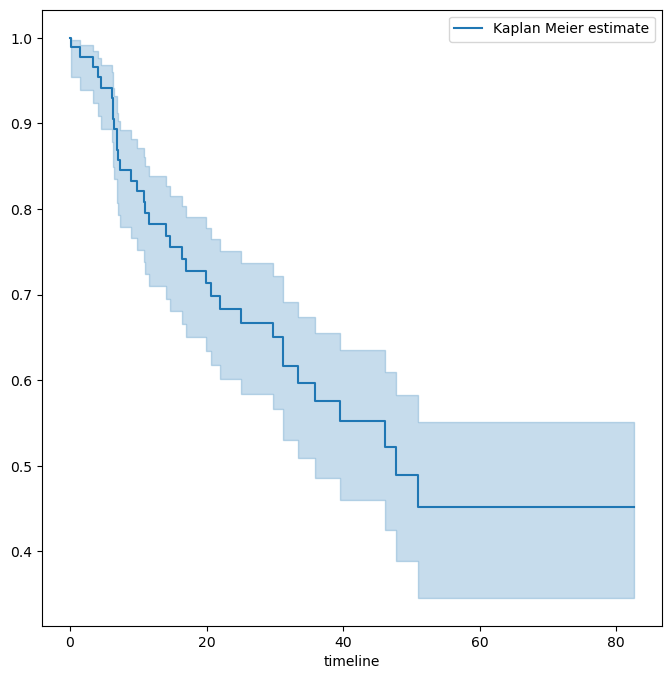

In [31]:
fig, ax = subplots(figsize=(8,8))
km = KaplanMeierFitter()
km_brain = km.fit(BrainCancer['time'], BrainCancer['status'],alpha=alpha)
km_brain.plot(label='Kaplan Meier estimate', ax=ax);

In [32]:
km_brain.survival_function_

,KM_estimate
timeline,
0.00,1.000000
0.07,0.988636
1.18,0.988636
1.41,0.977141
1.54,0.977141
...,...
65.02,0.451543
67.38,0.451543
73.74,0.451543


### (b)

In [7]:
BrainCancer.index

RangeIndex(start=0, stop=88, step=1)

In [8]:
#Define indexes of the bootstrap sample
rng=np.random.default_rng(0)
boot_index=rng.choice(BrainCancer.index,88,replace=True)

In [9]:
#Define the sample
sample=pd.DataFrame({'obs':BrainCancer['time'].iloc[boot_index],
                     'status':BrainCancer['status'].iloc[boot_index]})


In [10]:
km = KaplanMeierFitter()
km_brain = km.fit(sample['obs'], BrainCancer['status'],alpha=1)
km_brain.survival_function_

,KM_estimate
timeline,
0.00,1.000000
0.07,0.977273
1.18,0.977273
1.41,0.965639
2.03,0.954004
5.15,0.954004
5.51,0.941928
6.23,0.941928
7.05,0.941928


In [11]:
#Now let's repeat the process 200 times
B=200
km_brain_list=[]

for _ in range(B):
    boot_index=rng.choice(BrainCancer.index,88,replace=True)
    sample=pd.DataFrame({'obs':BrainCancer['time'].iloc[boot_index],
                     'status':BrainCancer['status'].iloc[boot_index]})
    km_brain_list.append(km.fit(sample['obs'], BrainCancer['status'],alpha=1))
survival=km_brain_list[0].survival_function_
for i in range(1,B):
    survival=survival+km_brain_list[i].survival_function_
survival=survival/B

In [59]:
survival

,KM_estimate
timeline,
0.00,1.000000
0.07,1.000000
1.18,1.000000
1.41,0.976471
2.03,0.976471
4.16,0.964415
4.56,0.952208
6.10,0.952208
6.23,0.952208


In [35]:
timeline=survival.index.values

In [24]:
#Compute the number of events at time t of the bootstrap survival function
q=[]
for i in range(len(timeline)):
    q.append(np.sum(BrainCancer['status'][BrainCancer['time']<timeline[i]]))

In [70]:
#Compute the difference between the number of subjects at risk and died subjects at time t of
#the bootstrap survival function
r=[]
for i in range(len(timeline)):
    r.append(np.count_nonzero(BrainCancer['status'][BrainCancer['time']>=timeline[i]]==0)
              +np.sum(BrainCancer['status']))

In [77]:
r_q=[]
for i in range(len(r)):
    r_q.append(r[i]-q[i])
rr_q=list(map(lambda x, y: x * y, r, r_q))
inv_rr_q=list(map(lambda x, y: x / y, [1]*len(rr_q), rr_q))
qinv_rr_q=list(map(lambda x, y: x * y, r, inv_rr_q))

In [78]:
len(qinv_rr_q)

56

In [92]:
#Now let's compute standard error of each each bootstraped survival observation using Greenwood formula
ste=[]
for i in range(len(timeline)):
    S2=survival.iloc[i]['KM_estimate']**2
    factor=0
    for j in range(i+1):
       factor+=qinv_rr_q[j] 
    ste.append(S2*factor)

In [93]:
ste_df=pd.DataFrame({'timeline':timeline,'Standard error':ste})

In [94]:
ste_df

,timeline,Standard error
0,0.00,0.011364
1,0.07,0.022727
2,1.18,0.034222
3,1.41,0.043717
4,2.03,0.055068
5,4.16,0.065060
6,4.56,0.074617
7,6.10,0.086241
8,6.23,0.098016
9,6.30,0.109947


### (c)

In [102]:
cleaned = BrainCancer.dropna()#delete the missing data
coxph = CoxPHFitter # shorthand
model_df=MS(cleaned,intercept=False).fit_transform(cleaned)
cox_fit = coxph().fit(model_df,'time','status')
cox_fit.summary[['coef', 'se(coef)', 'p']]

,coef,se(coef),p
covariate,,,
sex[Male],0.183748,0.360358,0.610119
diagnosis[LG glioma],-1.239530,0.579555,0.032455
diagnosis[Meningioma],-2.154566,0.450524,0.000002
diagnosis[Other],-1.268870,0.617672,0.039949
loc[Supratentorial],0.441195,0.703669,0.530665
ki,-0.054955,0.018314,0.002693
gtv,0.034293,0.022333,0.124661
stereo[SRT],0.177778,0.601578,0.767597


### (d)

In [105]:
BrainCancer['ki'].unique()

array([ 90,  70,  80, 100,  60,  40], dtype=int64)

In [119]:
cleaned['ki'][cleaned['ki']==40]

62    40
Name: ki, dtype: int64

In [123]:
cleaned['ki'] = cleaned['ki'].replace([40], [60])

C:\Users\kabousselham\AppData\Local\Temp\ipykernel_8224\804784288.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['ki'] = cleaned['ki'].replace([40], [60])


In [125]:
cleaned['ki'].iloc[62]

60

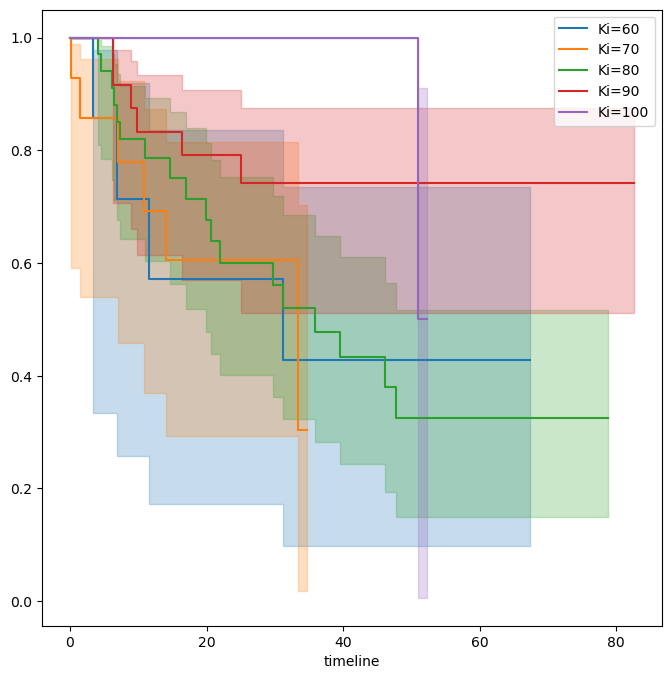

In [127]:
fig, ax = subplots(figsize=(8,8))
by_ki = {}
for ki, df in cleaned.groupby('ki'):
    by_ki[ki] = df
    km_ki = km.fit(df['time'], df['status'])
    km_ki.plot(label='Ki=%s' % ki, ax=ax)

## Exercise 11

In [135]:
#Let first create the table 11.4 in csv format and import it to do the assignments
df=pd.read_csv('table11_4.csv')

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y       6 non-null      float64
 1   delta   6 non-null      int64  
 2   X       6 non-null      float64
dtypes: float64(2), int64(1)
memory usage: 276.0 bytes


### (a)

In [139]:
df['group']=np.where(df['X']<2,1,2)

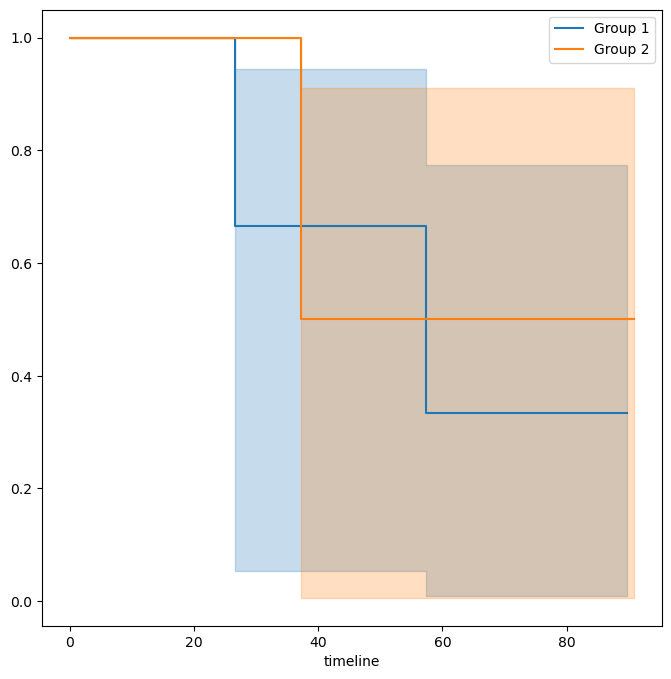

In [142]:
fig, ax = subplots(figsize=(8,8))
by_X = {}
for group, df12 in df.groupby('group'):
    by_X[group] = df12
    km_group = km.fit(df12['Y'], df12['delta'])
    km_group.plot(label='Group %s' % group, ax=ax)

We see the confidence intervals of both groups are quite the same. We conjecture that there is no significant difference between the two survival curves.

### (b)

In [143]:
coxph = CoxPHFitter
group_df=df[['Y','delta','group']]
model_df=MS(['Y','delta','group'],intercept=False).fit_transform(group_df)
cox_fit = coxph().fit(model_df,'Y','delta')
cox_fit.summary[['coef', 'se(coef)', 'p']]

,coef,se(coef),p
covariate,,,
group,-0.340143,1.235876,0.783144


The baseline group here is 1. The result shows that the risk associated with group 1
is more than 1.40 times (i.e. $e^{0.34}=1.404$) the risk associated
with group 2.

The resulting 𝑝-value is 0.78, indicating no evidence of a difference in survival between the two groups. Therefore, the true coefficient is significantly null.

### (c)

In [144]:
by_X

{1:       Y  delta    X  group
 0  26.5      1  0.1      1
 2  57.3      1 -0.3      1
 4  20.2      0  1.8      1
 5  89.8      0  0.4      1,
 2:       Y  delta     X  group
 1  37.2      1  11.0      2
 3  90.8      0   2.8      2}

In [146]:
logrank_test(by_X[1]['Y'],
             by_X[2]['Y'],
             by_X[1]['delta'],
             by_X[2]['delta'])

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.08 0.78      0.35

The resulting 𝑝-value is 0.78 for the log-rank test, which is the same value found for the Cox model.